<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Alternative_Assessment_Handwriting_Recognization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.utils import plot_model

# Distributed Training

In [2]:
# Detect hardware
try:
  # TPU Detector
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print("Running on TPU ")
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print("Running on multiple GPUs ",[gpu.name for gpu in gpus])
elif len(gpus) == 1:
  # strategy for single-machine execution
  strategy = tf.distribute.get_strategy()
  print("Running on single GPU ",gpus[0].name)
else:
  # strategy for single-machine execution
  strategy = tf.distribute.get_strategy()
  print("Running on single CPU ")

print("Number of accelerators ",strategy.num_replicas_in_sync)

Running on single CPU 
Number of accelerators  1


# Dataset Loading and Preprocessing

In [3]:
!git clone https://github.com/Walmond3/WIX3001-Alt-Ass

Cloning into 'WIX3001-Alt-Ass'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (12/12), 253.09 KiB | 6.33 MiB/s, done.


**Image Cropping**

In [4]:
def crop_image_into_pieces(image_path, output_folder, rows, columns, owner):
    # Open the image
    image = Image.open(image_path)

    # Convert image to RGB mode (remove alpha channel)
    image = image.convert("RGB")

    # Get the dimensions of the original image
    original_width, original_height = image.size

    # Calculate the width and height of each piece
    piece_width = original_width // columns
    piece_height = original_height // rows

    # Initialize a list to store data for each cropped image
    cropped_images_data = []

    # Iterate through each row and column
    for row in range(rows):
        for col in range(columns):
            # Calculate the coordinates for cropping
            left = col * piece_width
            upper = row * piece_height
            right = left + piece_width
            lower = upper + piece_height

            # Crop the image
            cropped_img = image.crop((left, upper, right, lower))

            # Invert the colors
            inverted_img = ImageOps.invert(cropped_img)

            # Create output subfolder if it doesn't exist
            os.makedirs(output_folder, exist_ok=True)

            # Save the cropped image
            output_filename = f"{owner}_crop_{row}_{col}.jpg"
            output_filepath = os.path.join(output_folder, output_filename)
            inverted_img.save(output_filepath)

            # Append data to the list for DataFrame
            cropped_images_data.append({
                "Filename": output_filename,
                "Filepath": output_filepath,
                "Owner": owner
            })
            # print(f"Saved {output_filename}")

    print(f"All crops for {owner} saved!")

    return cropped_images_data

# Directory where the images are stored
images_directory = "/content/WIX3001-Alt-Ass/Handwriting"

# Output folder to save cropped images within Colab
output_folder = "/content/output_crops"

# Number of rows and columns in the grid
rows = 12
columns = 12

# Check if the images directory exists
if not os.path.exists(images_directory):
    print(f"Error: {images_directory} does not exist.")
    exit()

# List all files in the images directory
image_files = os.listdir(images_directory)

# Check if there are any image files
if not image_files:
    print(f"No image files found in {images_directory}.")
    exit()

# Initialize a list to store all cropped images data
all_cropped_images_data = []

# Iterate through each image file
for image_file in image_files:
    image_path = os.path.join(images_directory, image_file)
    owner, _ = os.path.splitext(image_file)  # Get owner from filename without extension
    cropped_images_data = crop_image_into_pieces(image_path, output_folder, rows, columns, owner)

    # Testing
    all_cropped_images_data.extend(cropped_images_data)

All crops for Jin Khye saved!
All crops for Hui Yi saved!
All crops for Yan Hao saved!
All crops for Yan Ho saved!
All crops for Yee Sem saved!


**Store data in DataFrame**

In [5]:
# Create a DataFrame from the list of cropped images data
df = pd.DataFrame(all_cropped_images_data)
df.head()

,Filename,Filepath,Owner
0,Jin Khye_crop_0_0.jpg,/content/output_crops/Jin Khye_crop_0_0.jpg,Jin Khye
1,Jin Khye_crop_0_1.jpg,/content/output_crops/Jin Khye_crop_0_1.jpg,Jin Khye
2,Jin Khye_crop_0_2.jpg,/content/output_crops/Jin Khye_crop_0_2.jpg,Jin Khye
3,Jin Khye_crop_0_3.jpg,/content/output_crops/Jin Khye_crop_0_3.jpg,Jin Khye
4,Jin Khye_crop_0_4.jpg,/content/output_crops/Jin Khye_crop_0_4.jpg,Jin Khye


**Display Images**

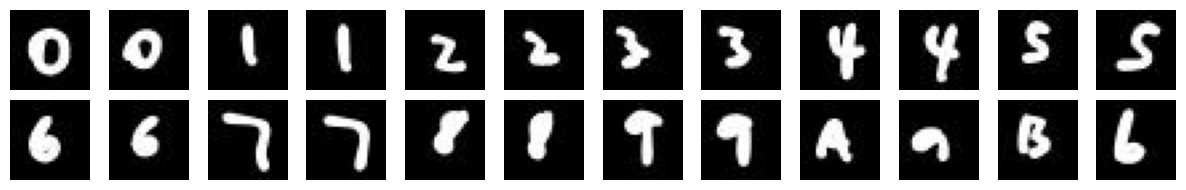

In [6]:
def display_images(filepaths):
    fig, axes = plt.subplots(len(filepaths) // columns, columns, figsize=(12, 2))
    for i, filepath in enumerate(filepaths):
        img = Image.open(filepath)
        ax = axes[i // columns, i % columns]
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Display the images
display_images(df['Filepath'][:24])

**Dataset spliting**

In [7]:
from sklearn.model_selection import train_test_split


train,test = train_test_split(df,test_size=0.1, random_state=42)

In [9]:
# Load Images
def load_and_preprocess_image(file_path):
    # Read the image file as raw data
    img = tf.io.read_file(file_path)
    # Decode the raw data into a tensor
    img = tf.image.decode_image(img, channels=3)
    return img

def format_image(image,label):
  image = tf.reshape(image,[-1])
  image = tf.cast(image, tf.float32)
  image /= 255
  return image, label

label_mapping = {'Yan Ho' : 0,'Jin Khye' : 1,'Hui Yi' : 2,'Yee Sem' : 3,'Yan Hao' : 4}

# Train dataset
train_image_paths = train['Filepath'].tolist()
train_label = np.array(train['Owner'].map(label_mapping))

# Test dataset
test_image_paths = test['Filepath'].tolist()
test_label =  np.array(test['Owner'].map(label_mapping))

# Load all images
train_images = [load_and_preprocess_image(path) for path in train_image_paths]
train_image_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_label))

test_images = [load_and_preprocess_image(path) for path in test_image_paths]
test_image_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_label))

In [10]:
train_batch_size = 32
test_batch_size = 8
train_dataset = train_image_dataset.shuffle(buffer_size=len(train)).batch(train_batch_size)
test_dataset = test_image_dataset.batch(test_batch_size)

In [11]:
class_names = list(df["Owner"].unique())
class_names

['Yan Ho', 'Yee Sem', 'Jin Khye', 'Yan Hao', 'Hui Yi']

# Define the Model

**Define Optimizers and Loss function**

In [12]:
# Define Optimizer and Loss Function
optimizer = tf.keras.optimizers.legacy.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Define metrics
train_acc_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metrics = tf.keras.metrics.SparseCategoricalAccuracy()

**Define gradient and training loop**

In [13]:
def apply_gradient(model_1,optimizer,loss_object,x,y):
  with tf.GradientTape() as tape:
    pred = model_1(x)
    loss_value = loss_object(y_true = y,y_pred = pred)

  gradients = tape.gradient(loss_value,model_1.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model_1.trainable_weights))

  return pred,loss_value

In [14]:
def perform_validation(model_1,test_dataset):
  losses = []
  for x_val,y_val in test_dataset:
    val_logits = model_1(x_val)
    val_loss = loss_object(y_true = y_val,y_pred = val_logits)

    losses.append(val_loss)
    test_acc_metrics(y_val,val_logits)

  return losses

In [15]:
def train_data_for_one_epoch(model_1,train_dataset):
  losses = []

  pbar = tqdm(total = len(list(enumerate(train_dataset))),position = 0, leave = True, bar_format = '{l_bar}{bar} | {n_fmt}/{total_fmt}')
  for step,(x_batch_train,y_batch_train) in enumerate(train_dataset):
    pred,loss_value = apply_gradient(model_1,optimizer,loss_object,x_batch_train,y_batch_train)
    losses.append(loss_value)

    train_acc_metrics(y_batch_train,pred)
    pbar.set_description("Training loss for step %s: %.4f" % (int(step),float(loss_value)))
    pbar.update()


  return losses

**Transfer Learning - InceptionV3**

In [16]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-05-22 06:38:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   150MB/s    in 0.6s    

2024-05-22 06:38:40 (150 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [38]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras import layers


def feature_extractor_inceptionV3(inputs):
  # Set the weights file you downloaded into a variable
  local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

  # Initialize the base model
  # Set the input shape and remove the dense layer
  feature_extractor = InceptionV3(input_shape = (300,300,3),
                                  include_top = False,
                                  weights = None)
  # Load the pre-trained weights
  feature_extractor.load_weights(local_weights_file)

  # Freeze the weights of the layers
  for layer in feature_extractor.layers:
    layer.trainable = False

  feature_extractor = feature_extractor(inputs)

  return feature_extractor

def classifier(inputs):
  x = layers.GlobalAveragePooling2D()(inputs)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(1024,activation = 'relu')(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(512,activation = 'relu')(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(5,activation = 'softmax')(x)

  return x

def model_1():
  inputs = layers.Input(shape = (30,30,3))
  resize = layers.UpSampling2D(size = (10,10))(inputs)
  inception = feature_extractor_inceptionV3(resize)
  classification_output = classifier(inception)
  model = Model(inputs = inputs,outputs = classification_output)

  return model

def train_model(model_1,train_dataset,test_dataset,epochs = 30):

  epochs_test_losses,epochs_train_losses = [],[]
  epochs_test_acc,epochs_train_acc = [],[]

  for epoch in range(epochs):
    print("Epoch : ",epoch+1)

    losses_train = train_data_for_one_epoch(model_1,train_dataset)
    train_acc = train_acc_metrics.result()

    losses_test = perform_validation(model_1,test_dataset)
    test_acc = test_acc_metrics.result()

    losses_train_mean = np.mean(losses_train)
    losses_test_mean = np.mean(losses_test)
    epochs_train_losses.append(losses_train_mean)
    epochs_test_losses.append(losses_test_mean)

    epochs_train_acc.append(train_acc)
    epochs_test_acc.append(test_acc)

    print("Train loss : {:8.4f}, Validation loss : {:8.4f}, Train Accuracy : {:6.3f}, Test Accuracy : {:6.3f}\n".format(
        float(losses_train_mean),float(losses_test_mean),float(train_acc),float(test_acc)
    ))

    train_acc_metrics.reset_states()
    test_acc_metrics.reset_states()

  history = {
      'accuracy' : epochs_train_acc,
      'test_accuracy' : epochs_test_acc,
      'loss' : epochs_train_losses,
      'test_loss' : epochs_test_losses
  }

  return history

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 30, 30, 3)]       0         
                                                                 
 up_sampling2d_6 (UpSamplin  (None, 300, 300, 3)       0         
 g2D)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0   

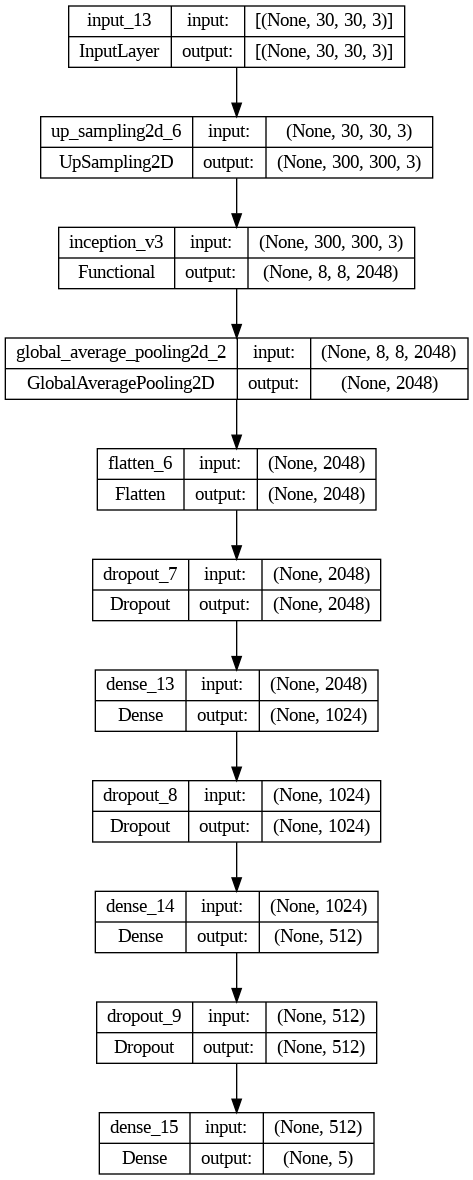

In [39]:
model_1 = model_1()
model_1.summary()
plot_model(model_1,show_shapes=True, show_layer_names=True)

In [40]:
history = train_model(model_1,train_dataset,test_dataset,epochs = 15)

Epoch :  1


Training loss for step 20: 25.6946: 100%|██████████ | 21/21


Train loss : 126.4787, Validation loss :   6.6324, Train Accuracy :  0.205, Test Accuracy :  0.250

Epoch :  2


Training loss for step 20: 2.0985: 100%|██████████ | 21/21


Train loss :   5.9304, Validation loss :   1.8589, Train Accuracy :  0.241, Test Accuracy :  0.194

Epoch :  3


Training loss for step 20: 1.3199: 100%|██████████ | 21/21


Train loss :   1.5113, Validation loss :   1.5221, Train Accuracy :  0.360, Test Accuracy :  0.333

Epoch :  4


Training loss for step 20: 1.1373: 100%|██████████ | 21/21


Train loss :   1.3101, Validation loss :   1.5489, Train Accuracy :  0.438, Test Accuracy :  0.319

Epoch :  5


Training loss for step 20: 1.3891: 100%|██████████ | 21/21


Train loss :   1.1952, Validation loss :   1.2576, Train Accuracy :  0.498, Test Accuracy :  0.458

Epoch :  6


Training loss for step 20: 1.0067: 100%|██████████ | 21/21


Train loss :   1.0632, Validation loss :   1.3798, Train Accuracy :  0.577, Test Accuracy :  0.403

Epoch :  7


Training loss for step 20: 1.0177: 100%|██████████ | 21/21


Train loss :   1.0387, Validation loss :   1.1708, Train Accuracy :  0.565, Test Accuracy :  0.500

Epoch :  8


Training loss for step 20: 1.1200: 100%|██████████ | 21/21


Train loss :   0.9458, Validation loss :   1.4154, Train Accuracy :  0.628, Test Accuracy :  0.431

Epoch :  9


Training loss for step 20: 1.0228: 100%|██████████ | 21/21


Train loss :   0.8723, Validation loss :   1.3367, Train Accuracy :  0.664, Test Accuracy :  0.514

Epoch :  10


Training loss for step 20: 0.8584: 100%|██████████ | 21/21


Train loss :   0.9198, Validation loss :   1.1366, Train Accuracy :  0.647, Test Accuracy :  0.500

Epoch :  11


Training loss for step 20: 0.6476: 100%|██████████ | 21/21


Train loss :   0.8000, Validation loss :   1.0077, Train Accuracy :  0.693, Test Accuracy :  0.597

Epoch :  12


Training loss for step 20: 0.8407: 100%|██████████ | 21/21


Train loss :   0.7268, Validation loss :   1.2854, Train Accuracy :  0.716, Test Accuracy :  0.542

Epoch :  13


Training loss for step 20: 0.4677: 100%|██████████ | 21/21


Train loss :   0.6762, Validation loss :   1.0648, Train Accuracy :  0.738, Test Accuracy :  0.569

Epoch :  14


Training loss for step 20: 1.0344: 100%|██████████ | 21/21


Train loss :   0.7011, Validation loss :   1.1446, Train Accuracy :  0.739, Test Accuracy :  0.569

Epoch :  15


Training loss for step 20: 0.6238: 100%|██████████ | 21/21


Train loss :   0.6180, Validation loss :   0.9912, Train Accuracy :  0.741, Test Accuracy :  0.625



In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale = 1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='Filepath',
    y_col = 'Owner',
    target_size = (150,150),
    class_mode = 'categorical'
)

# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale = 1/255)

# Flow training images in batches of 128 using train_datagen generator
test_generator = test_datagen.flow_from_dataframe(
    test,
    x_col='Filepath',
    y_col = 'Owner',
    target_size = (150,150),
    class_mode = 'categorical'
)


Found 648 validated image filenames belonging to 5 classes.
Found 72 validated image filenames belonging to 5 classes.


In [11]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-05-22 07:51:46--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 173.194.213.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   133MB/s    in 0.6s    

2024-05-22 07:51:47 (133 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Initialize the base model
# Set the input shape and remove the dense layer
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

# Flatten the output layer to 1 dimension
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation = 'relu')(x)
# Add Dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final softmax layer for classification
x = layers.Dense(5,activation = 'softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input,x)

# Print the model summary
# model.summary()
model.compile(optimizer = RMSprop(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])


model.fit(
    train_generator,
    epochs = 15,
    batch_size = 32,
    validation_data = test_generator
)


Epoch 1/15
21/21 [==============================] - 50s 2s/step - loss: 1.5599 - accuracy: 0.4552 - val_loss: 1.0130 - val_accuracy: 0.5833
Epoch 2/15
21/21 [==============================] - 43s 2s/step - loss: 0.8409 - accuracy: 0.6960 - val_loss: 1.0546 - val_accuracy: 0.6111
Epoch 3/15
21/21 [==============================] - 44s 2s/step - loss: 0.6208 - accuracy: 0.7731 - val_loss: 0.9387 - val_accuracy: 0.6528
Epoch 4/15
21/21 [==============================] - 45s 2s/step - loss: 0.5011 - accuracy: 0.8133 - val_loss: 1.0054 - val_accuracy: 0.6389
Epoch 5/15
21/21 [==============================] - 44s 2s/step - loss: 0.3268 - accuracy: 0.8858 - val_loss: 1.4285 - val_accuracy: 0.5972
Epoch 6/15
21/21 [==============================] - 42s 2s/step - loss: 0.2392 - accuracy: 0.9244 - val_loss: 1.1343 - val_accuracy: 0.5694
Epoch 7/15
21/21 [==============================] - 42s 2s/step - loss: 0.2576 - accuracy: 0.9136 - val_loss: 1.0475 - val_accuracy: 0.7083
Epoch 8/15
21/21 [==

# Visualize Results

# Visualize Predictions

In [ ]:
def display_images(images, predictions, labels, title, n):
    fig, axes = plt.subplots(1, n, figsize=(17, 3))
    fig.suptitle(title)

    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Pred: {predictions[i]}\nTrue: {labels[i]}")
        axes[i].axis('off')

    plt.show()

x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_dataset:
    y_pred = model_1(x)
    y_pred_batches.append(y_pred)
    y_true_batches.append(y)
    x_batches.append(x)

x_batches = np.concatenate(x_batches)
y_pred_batches = np.concatenate(y_pred_batches)
y_true_batches = np.concatenate(y_true_batches)

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]

display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)